## Bitcoin Price Predictor

#### Predict next day stock price using last 60 days data

### Imports:

In [37]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler

import time
from collections import deque
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, CuDNNLSTM, BatchNormalization

### Data Import:

In [38]:
df = pd.read_csv("BTC-USD.CSV", names=["time", "low", "high","open","close","volume"])
df.set_index("time", inplace=True)
df = df[["close"]]
df.head()

,close
time,
1528968660,6489.549805
1528968720,6487.379883
1528968780,6479.410156
1528968840,6479.410156
1528968900,6479.979980


In [39]:
SEQ_LENGTH = 60 #no. of previous days from which to predict

sc = StandardScaler()

def preprocess_df(df):
    sc_train = StandardScaler()
    df = df.dropna()

    df_array = sc.fit_transform(df)

    sequential_data = []
    prev_days = deque(maxlen=SEQ_LENGTH)

    for f in df_array: #list of rows
        prev_days.append(f)
        if len(prev_days) == SEQ_LENGTH:
            sequential_data.append([np.array(prev_days)[:-1], f]) # feature set and labels
    
    random.shuffle(sequential_data)

    x = []
    y = []

    for seq, target in sequential_data:
        x.append(seq)
        y.append(target)
    
    return np.array(x), np.array(y)

### Data Preparation and Split:

In [40]:
times = sorted(df.index.values)

last_5pct = times[-int(0.05*len(times))] # returns index

#Splitting data
validation_df = df[(df.index >= last_5pct)]
df = df[(df.index < last_5pct)]

train_x, train_y = preprocess_df(df)

validation_x, validation_y = preprocess_df(validation_df)

### Construct RNN Model

In [41]:
model = Sequential()

model.add(CuDNNLSTM(50, input_shape=train_x.shape[1:], return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(50, input_shape=train_x.shape[1:]))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

model.compile(loss='mean_squared_error',
	optimizer=opt,
	metrics=['mse'])

### Train Model

In [42]:
EPOCHS = 10
BATCH_SIZE = 64

model.fit(train_x, train_y,
	epochs=EPOCHS,
	batch_size=BATCH_SIZE,
	validation_data=(validation_x, validation_y))

Train on 92779 samples, validate on 4827 samples
Epoch 1/10
92779/92779 [==============================] - 54s 583us/step - loss: 0.0814 - mean_squared_error: 0.0814 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 2/10
92779/92779 [==============================] - 53s 567us/step - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 3/10
92779/92779 [==============================] - 51s 551us/step - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 4/10
92779/92779 [==============================] - 53s 569us/step - loss: 0.0241 - mean_squared_error: 0.0241 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 5/10
92779/92779 [==============================] - 53s 568us/step - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 6/10
92779/92779 [==============================] - 51s 552us/step - loss: 0.0217 - mean_squared_err

### Visualize the predictions

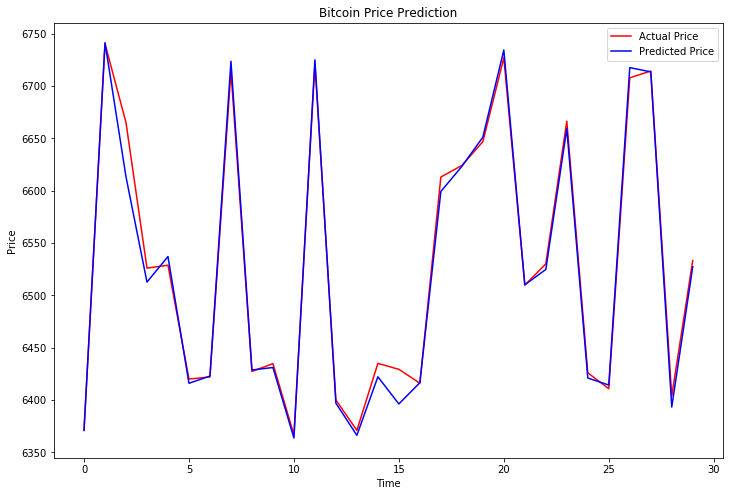

In [46]:
plt.figure(figsize=(12,8))
plt.plot(sc.inverse_transform(validation_y[-30:]), color='red', label="Actual Price")
plt.plot(sc.inverse_transform(model.predict(validation_x[-30:])), color="blue", label="Predicted Price")
plt.title("Bitcoin Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()